# Univariate Analysis

### Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind

### Loading the preprocessed dataset

In [5]:
#loading the dataset
df=pd.read_csv("heart_cleaned.csv")

#### 1) Display the first five rows and shape

In [7]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   62    0   0       138   294    1        1      106      0      1.9      1   
1   58    0   0       100   248    0        0      122      0      1.0      1   
2   58    1   0       114   318    0        2      140      0      4.4      0   
3   54    1   0       122   286    0        0      116      1      3.2      1   
4   71    0   0       112   149    0        1      125      0      1.6      1   

   ca  thal  target  
0   3     2       0  
1   0     2       1  
2   3     1       0  
3   2     2       0  
4   0     2       1

In [11]:
row=df.shape[0]
column=df.shape[1]
print(f"Total number of rows:{row}\nTotal number of columns:{column}")

Total number of rows:183
Total number of columns:14


#### 2) Which variables in the dataset are numerical, and which are categorical?

In [14]:
#Identify quantitative(numerical) and qualitative(categorical) columns
def quanqual(df):
    quan=[]
    qual=[]
    for i in df.columns:
        if df[i].nunique()<=5:
            qual.append(i)
        else:
            quan.append(i)
    return quan,qual


In [16]:
quan,qual=quanqual(df)

In [18]:
print(f"Numerical variables:{quan}\nCategorical variables:{qual}")

Numerical variables:['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical variables:['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']


#### 3) What are the detailed descriptive statistics of the numerical variables in the dataset?

In [21]:
#descriptive statistics
def Univariate(df,quan):
    descriptive=pd.DataFrame(index=["Mean","Median","Mode","Q1:25%","Q2:50%","Q3:75%","99%","Q4:100%","IQR","1.5rule","Lower_Bound","Upper_Bound","Min","Max","Skew","Kurtosis","Variance","Standard_Deviation"],columns=quan)
    for columnName in quan:
        descriptive.loc["Mean",columnName]=df[columnName].mean()
        descriptive.loc["Median",columnName]=df[columnName].median()
        descriptive.loc["Mode",columnName]=df[columnName].mode()[0]
        descriptive.loc["Q1:25%",columnName]=np.percentile(df[columnName],25)
        descriptive.loc["Q2:50%",columnName]=np.percentile(df[columnName],50)
        descriptive.loc["Q3:75%",columnName]=np.percentile(df[columnName],75)
        descriptive.loc["99%",columnName]=np.percentile(df[columnName],99)
        descriptive.loc["Q4:100%",columnName]=np.percentile(df[columnName],100)
        descriptive.loc["IQR",columnName]=descriptive.loc["Q3:75%",columnName]-descriptive.loc["Q1:25%",columnName]
        descriptive.loc["1.5rule",columnName]=1.5*descriptive.loc["IQR",columnName]
        descriptive.loc["Lower_Bound",columnName]= descriptive.loc["Q1:25%",columnName]-descriptive.loc["1.5rule",columnName]
        descriptive.loc["Upper_Bound",columnName]= descriptive.loc["Q3:75%",columnName]+descriptive.loc["1.5rule",columnName]
        descriptive.loc["Min",columnName]=df[columnName].min()
        descriptive.loc["Max",columnName]=df[columnName].max()
        descriptive.loc["Skew", columnName] = df[columnName].skew()
        descriptive.loc["Kurtosis", columnName] = df[columnName].kurtosis()
        descriptive.loc["Variance", columnName] = df[columnName].var()
        descriptive.loc["Standard_Deviation", columnName] = df[columnName].std()
    return descriptive

In [23]:
descriptive_stats = Univariate(df,quan)
print("Descriptive_Statistics:\n",descriptive_stats)

Descriptive_Statistics:
                           age    trestbps         chol     thalach   oldpeak
Mean                53.748634  129.972678    244.68306  153.256831  0.774317
Median                   54.0       130.0        240.0       158.0       0.4
Mode                       44         130          204         152       0.0
Q1:25%                   45.5       120.0        209.5       142.0       0.0
Q2:50%                   54.0       130.0        240.0       158.0       0.4
Q3:75%                   61.0       140.0        273.0       170.0       1.4
99%                     74.36      175.08       366.12      190.36       3.6
Q4:100%                  77.0       180.0        417.0       202.0       4.4
IQR                      15.5        20.0         63.5        28.0       1.4
1.5rule                 23.25        30.0        95.25        42.0       2.1
Lower_Bound             22.25        90.0       114.25       100.0      -2.1
Upper_Bound             84.25       170.0       368

#### 4) Does the dataset contain any outliers in the numerical variables?

In [26]:
def finding_outlier(descriptive_stats,quan):
    lower_outlier=[]
    upper_outlier=[]
    for columnName in quan:
        if (descriptive_stats[columnName]['Min']<descriptive_stats[columnName]['Lower_Bound']):
            lower_outlier.append(columnName)
        if (descriptive_stats[columnName]['Max']>descriptive_stats[columnName]['Upper_Bound']):
            upper_outlier.append(columnName)
    return lower_outlier,upper_outlier
    

In [28]:
lower_outlier,upper_outlier=finding_outlier(descriptive_stats,quan)

In [30]:
print(f"Lower Outliers:{lower_outlier}")
print(f"Upper Outliers:{upper_outlier}")

Lower Outliers:['thalach']
Upper Outliers:['trestbps', 'chol', 'oldpeak']


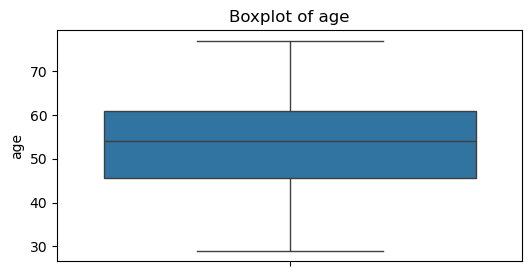

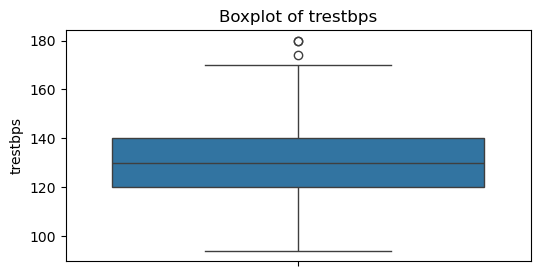

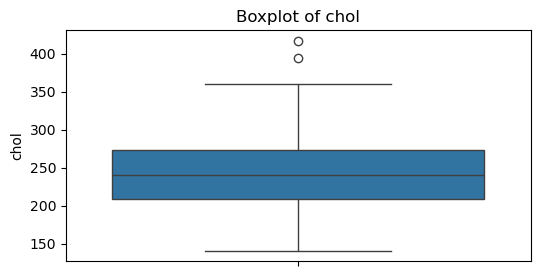

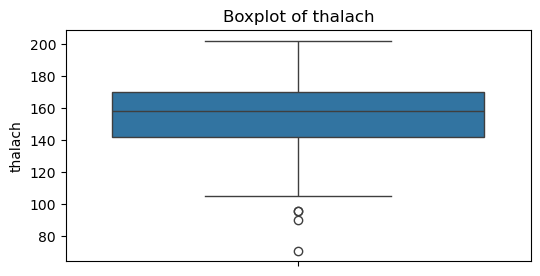

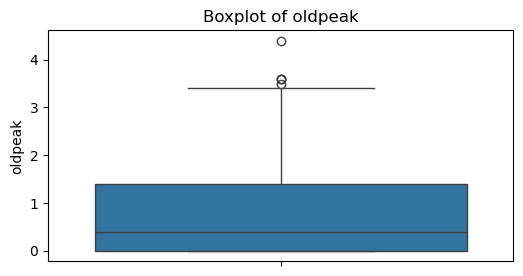

In [32]:
for column in quan:
    plt.figure(figsize=(6,3))
    sns.boxplot(df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

### Observation:
##### Age does not have any outliers.
##### thalach shows lower bound outliers-some patients have low maximum heart rates.
##### trestbps, chol and oldpeak shows upper bound outliers-some patients have high resting blood pressure ,cholesterol, and ST depression.

#### 5) How can outliers in numerical variables be replaced, and what is the effect on descriptive statistics after replacement?

In [36]:
def replacing_outlier(descriptive_stats,df,lower_outlier,upper_outlier):
    for columnName in lower_outlier:
        df.loc[df[columnName]<descriptive_stats[columnName]['Lower_Bound'],columnName]=descriptive_stats[columnName]['Lower_Bound']
    for columnName in upper_outlier:
        df.loc[df[columnName]>descriptive_stats[columnName]['Upper_Bound'],columnName]=descriptive_stats[columnName]['Upper_Bound']
    return df

In [38]:
df=replacing_outlier(descriptive_stats,df,lower_outlier,upper_outlier)
descriptive=Univariate(df,quan)

C:\Users\User\AppData\Local\Temp\ipykernel_20912\1757716547.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '368.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[columnName]>descriptive_stats[columnName]['Upper_Bound'],columnName]=descriptive_stats[columnName]['Upper_Bound']


In [40]:
descriptive

age    trestbps         chol     thalach   oldpeak
Mean                53.748634   129.84153   244.275956  153.513661   0.76776
Median                   54.0       130.0        240.0       158.0       0.4
Mode                       44         130        204.0         152       0.0
Q1:25%                   45.5       120.0        209.5       142.0       0.0
Q2:50%                   54.0       130.0        240.0       158.0       0.4
Q3:75%                   61.0       140.0        273.0       170.0       1.4
99%                     74.36       170.0      361.485      190.36       3.5
Q4:100%                  77.0       170.0       368.25       202.0       3.5
IQR                      15.5        20.0         63.5        28.0       1.4
1.5rule                 23.25        30.0        95.25        42.0       2.1
Lower_Bound             22.25        90.0       114.25       100.0      -2.1
Upper_Bound             84.25       170.0       368.25       212.0       3.5
Min                        29          94        141.0         100       0.0
Max                        77         170       368.25         202       3.5
Skew                -0.011726    0.353882     0.378876   -0.578719  1.234866
Kurtosis            -0.632387    -0.16477    -0.241636   -0.296286  0.740753
Variance            91.903501  253.716508  2209.858182  485.503933  0.911537
Standard_Deviation   9.586631   15.928481    47.009129   22.034154  0.954745

In [42]:
lower_outlier,upper_outlier=finding_outlier(descriptive,quan)

In [44]:
lower_outlier#no outliers

[]

In [46]:
upper_outlier#no outliers

[]

#### 6) What is the distribution of each numerical variable in the dataset?

#### a) What is the distribution of age?

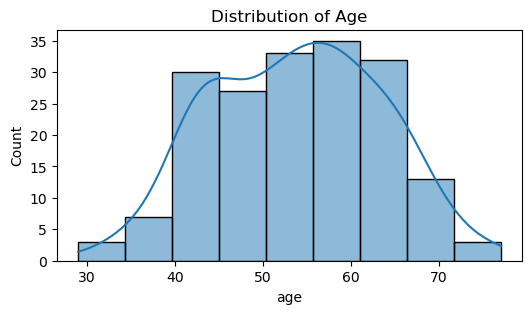

In [50]:
plt.figure(figsize=(6,3))
sns.histplot(df["age"], kde=True)
plt.title(f"Distribution of Age")
plt.show()

### Observation: 
##### Distribution of Age is slightly normal, ranging from 29 to 77 years, with most patients around 55 to 60 years. 

#### b) What is the distribution of trestbps?

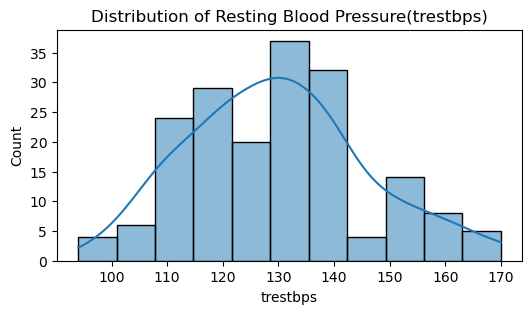

In [54]:
plt.figure(figsize=(6,3))
sns.histplot(df["trestbps"], kde=True)
plt.title(f"Distribution of Resting Blood Pressure(trestbps)")
plt.show()

### Observation:
##### Distribution of resting blood pressure(trestbps) is approximately normal, ranging from 94 to 170 mmHg, with most patients around 129 to 135 mmHg.

#### c) What is the distribution of cholesterol?

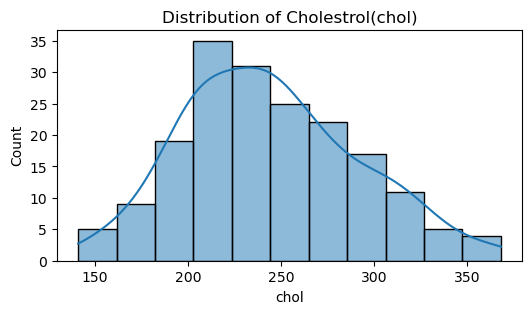

In [58]:
plt.figure(figsize=(6,3))
sns.histplot(df["chol"], kde=True)
plt.title(f"Distribution of Cholestrol(chol)")
plt.show()

### Observation:
##### Distribution of cholesterol(chol) is approximately normal with a slight positive skew, ranging from 141 to 368 mg/dL, with most patients around 202  to 225 mg/dL.

#### d) What is the distribution of thalach?

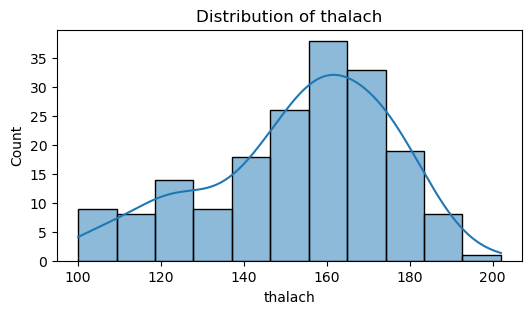

In [62]:
plt.figure(figsize=(6,3))
sns.histplot(df["thalach"], kde=True)
plt.title(f"Distribution of thalach")
plt.show()

### Observation:
##### Distribution of maximum heart rate acheived(thalach) is left-skewed, ranging from 100 to 202 bpm , with most patients around 158 to 162 bpm. 

#### e) What is the distribution of oldpeak?

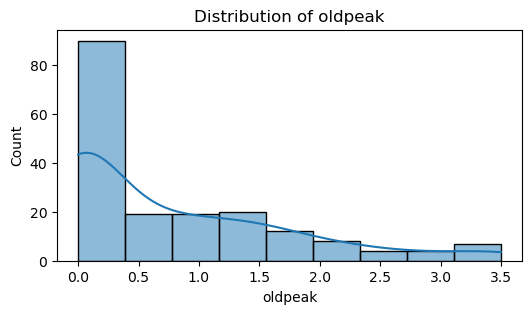

In [66]:
plt.figure(figsize=(6,3))
sns.histplot(df["oldpeak"], kde=True)
plt.title(f"Distribution of oldpeak")
plt.show()

### Observation:
##### Distribution of oldpeak is highly right-skewed, ranging from 0.0 to 3.5, with most patients around 0.0 to 0.4. 

In [69]:
# Map categorical variables
df["target_label"] = df["target"].map({0:"No Heart Disease", 1:"Heart Disease"})
df["sex_label"] = df["sex"].map({0:"Female", 1:"Male"})
df["cp_label"] = df["cp"].map({0:"Typical angina", 1:"Atypical angina", 2:"Non-Anginal pain", 3:"Asymptomatic"})
df["fbs_label"] = df["fbs"].map({0:"Normal(<120mg/dL)", 1:"High(>120mg/dL)"})
df["restecg_label"] = df["restecg"].map({0:"Normal", 1:"ST-T Abnormality", 2:"LVH"})
df["exang_label"] = df["exang"].map({0:"No", 1:"Yes"})
df["slope_label"] = df["slope"].map({0:"Upsloping", 1:"Flat", 2:"Downsloping"})
df["ca_label"] = df["ca"].map({0:"No Vessels", 1:"One vessel", 2:"Two vessels", 3:"Three vessels"})
df["thal_label"] = df["thal"].map({0:"Normal", 1:"Fixed Defect", 2:"Reversible defect"})

#### 7) What is the distribution of each categorical variable in the dataset?

In [72]:
def freqTable(columnName,df):
    freqTable=pd.DataFrame(columns=["Unique_values","Frequency","Relative_Frequency","Cumsum"])
    freqTable["Unique_values"]=df[columnName].value_counts().index
    freqTable["Frequency"]=df[columnName].value_counts().values
    freqTable["Relative_Frequency"]=(freqTable["Frequency"]/len(df))
    freqTable["Cumsum"]=freqTable["Relative_Frequency"].cumsum()
    return freqTable

#### a) How many patients are male and female?

In [75]:
freq_Table_sex=freqTable("sex",df)
freq_Table_sex

Unique_values  Frequency  Relative_Frequency    Cumsum
0              1        102            0.557377  0.557377
1              0         81            0.442623  1.000000

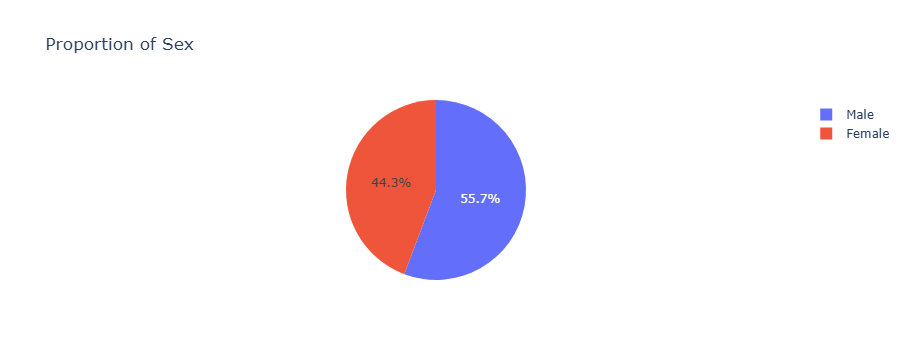

In [77]:
fig = px.pie(df, names="sex_label", title='Proportion of Sex')
fig.show()

### Observation:
##### 102(55.7%) patients are male.
##### 81(44.3%) patients are female.
##### Overall,most patients are male.

#### b) How many patients have each type of chest pain?

In [81]:
freq_Table_cp=freqTable("cp",df)
freq_Table_cp

Unique_values  Frequency  Relative_Frequency    Cumsum
0              0         65            0.355191  0.355191
1              2         62            0.338798  0.693989
2              1         41            0.224044  0.918033
3              3         15            0.081967  1.000000

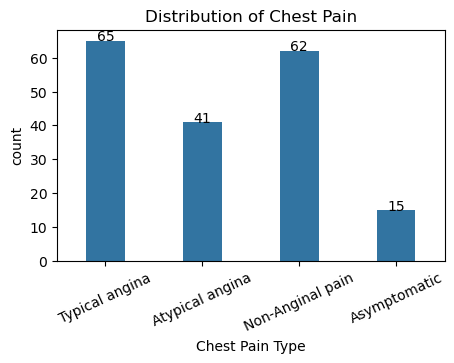

In [83]:
plt.figure(figsize=(5,3))
ax=sns.countplot(x="cp_label",data=df,width=0.4)
plt.title("Distribution of Chest Pain")
plt.xticks(rotation=25)
plt.xlabel("Chest Pain Type")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observation:
##### 65 patients have typical angina(high risk).
##### 62 patients have atypical angina(moderate risk).
##### 41 patients have non-anginal chest pain(low risk).
##### 15 patients have asymptomatic chest pain(low risk).
##### Overall,most patients have typical angina,indicating higher risk.

#### c) How many patients have fasting blood sugar?

In [87]:
freq_Table_fbs=freqTable("fbs",df)
freq_Table_fbs

Unique_values  Frequency  Relative_Frequency    Cumsum
0              0        157            0.857923  0.857923
1              1         26            0.142077  1.000000

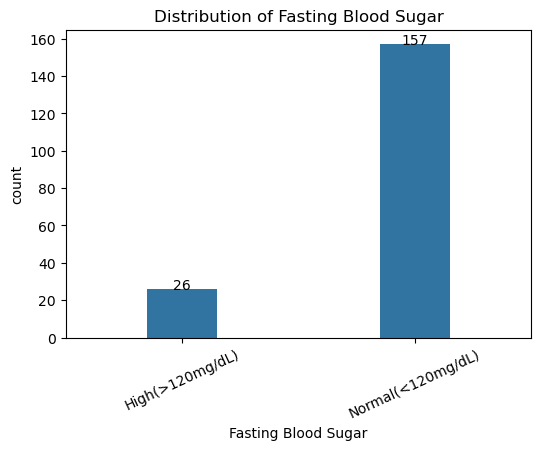

In [89]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="fbs_label",width=0.3)
plt.title("Distribution of Fasting Blood Sugar")
plt.xticks(rotation=25)
plt.xlabel("Fasting Blood Sugar")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

## Observation:
##### 157 patients have normal fasting blood sugar(fbs<120 mg/dL).
##### 26 patients have high fasting blood sugar(fbs>120 mg/dL).
##### Overall,most patients have normal fasting blood sugar.

#### d) How many patients have each type restecg?

In [93]:
freq_Table_restecg=freqTable("restecg",df)
freq_Table_restecg

Unique_values  Frequency  Relative_Frequency    Cumsum
0              1         91            0.497268  0.497268
1              0         89            0.486339  0.983607
2              2          3            0.016393  1.000000

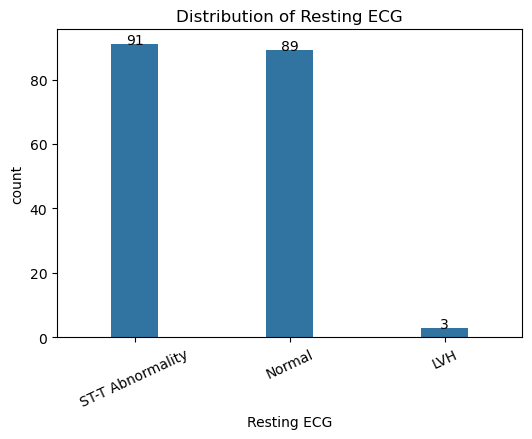

In [95]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="restecg_label",width=0.3)
plt.title("Distribution of Resting ECG")
plt.xticks(rotation=25)
plt.xlabel("Resting ECG")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observation:
##### 91 patients have ST-T abnormality(moderate risk).
##### 89 patients have normal resting ecg(low risk).
##### 3 patients have LVH(high risk).
##### Overall,most patients have ST-T abnormality,indicating moderate to high risk of heart disease.

#### e) How many patients have exercise induced angina(exang)?

In [99]:
freq_Table_exang=freqTable("exang",df)
freq_Table_exang

Unique_values  Frequency  Relative_Frequency    Cumsum
0              0        143            0.781421  0.781421
1              1         40            0.218579  1.000000

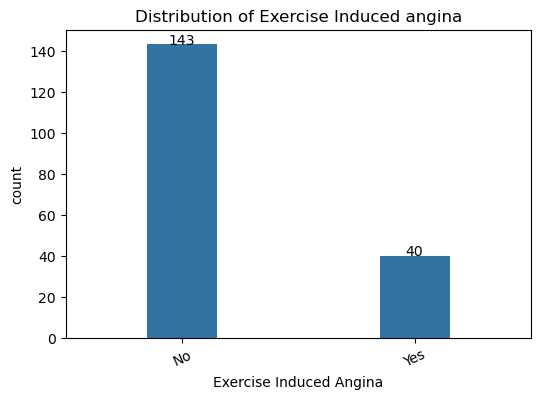

In [101]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="exang_label",width=0.3)
plt.title("Distribution of Exercise Induced angina")
plt.xticks(rotation=25)
plt.xlabel("Exercise Induced Angina")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observations:
##### 143 patients do not experience chest pain during exercise.
##### 40 patients experience chest pain during exercise.
##### Overall,most patients do not experience exercise induced angina.

#### f) How many patients have each type of slope?

In [105]:
freq_Table_slope=freqTable("slope",df)
freq_Table_slope

Unique_values  Frequency  Relative_Frequency    Cumsum
0              2        102            0.557377  0.557377
1              1         70            0.382514  0.939891
2              0         11            0.060109  1.000000

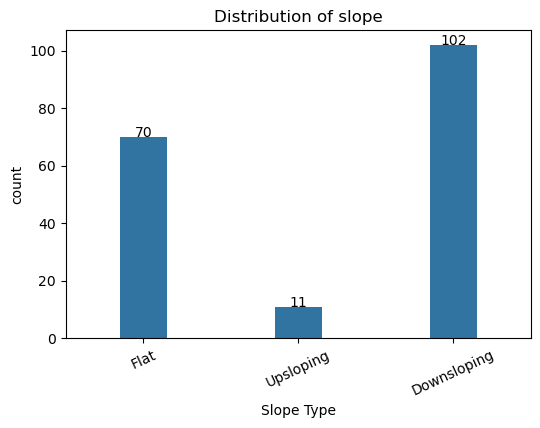

In [107]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="slope_label",width=0.3)
plt.title("Distribution of slope")
plt.xticks(rotation=25)
plt.xlabel("Slope Type")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observations:
##### 102 patients have downsloping ST segment(high risk).
##### 70 patients have flat ST segment(moderate risk).
##### 11 patients have upsloping ST segment rise(normal).
##### Overall,most patients have a downsloping ST segment,indicating higher risk.

#### g) What is the distribution of the number of major vessels colored(ca) among the patients?

In [111]:
freq_Table_ca=freqTable("ca",df)
freq_Table_ca

Unique_values  Frequency  Relative_Frequency    Cumsum
0              0        124            0.677596  0.677596
1              1         33            0.180328  0.857923
2              2         18            0.098361  0.956284
3              3          8            0.043716  1.000000

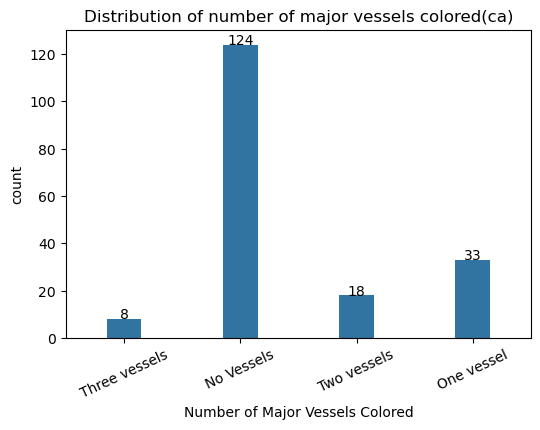

In [113]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="ca_label",width=0.3)
plt.title("Distribution of number of major vessels colored(ca)")
plt.xticks(rotation=25)
plt.xlabel("Number of Major Vessels Colored")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observation:
##### 124 patients have no vessels colored.
##### 33 patients have one vessel colored.
##### 18 patients have two vessels colored.
##### 8 patients have three vessels colored.
##### Overall, most of the patients have no major vessels colored,indicating lower coronary blockage.

#### h) How many patients belongs to each type of thalassemia(thal)?

In [117]:
freq_Table_thal=freqTable("thal",df)
freq_Table_thal

Unique_values  Frequency  Relative_Frequency    Cumsum
0              2        163            0.890710  0.890710
1              1         18            0.098361  0.989071
2              0          2            0.010929  1.000000

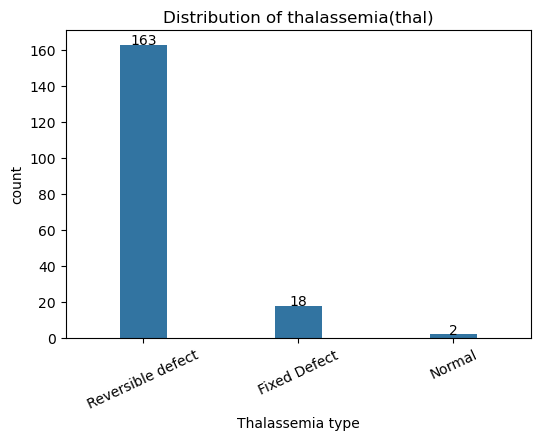

In [119]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="thal_label",width=0.3)
plt.title("Distribution of thalassemia(thal)")
plt.xticks(rotation=25)
plt.xlabel("Thalassemia type")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observation:
##### 163 patients have a fixed defect(permanent blood flow defect).
##### 18 patients have a reversible defect(temporary blood flow defect).
##### 2 patients have normal blood flow.
##### Overall,most patients have fixed defect,indicating blood flow abnormality.

#### i) What is the distribution of target?

In [123]:
freq_Table_target=freqTable("target",df)
freq_Table_target

Unique_values  Frequency  Relative_Frequency   Cumsum
0              1        134             0.73224  0.73224
1              0         49             0.26776  1.00000

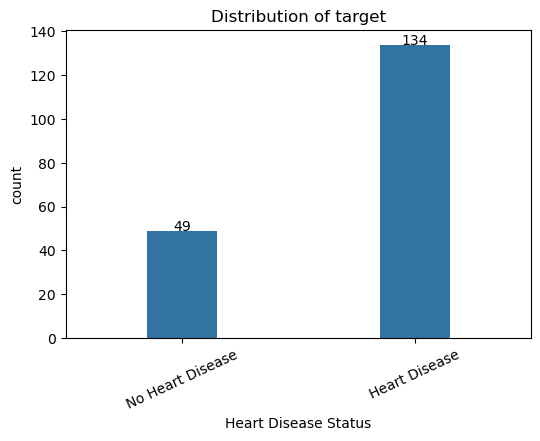

In [125]:
plt.figure(figsize=(6,4))
ax=sns.countplot(data=df,x="target_label",width=0.3)
plt.title("Distribution of target")
plt.xticks(rotation=25)
plt.xlabel("Heart Disease Status")
for p in ax.patches:
    ax.annotate(int(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),ha='center')
plt.show()

### Observation:
##### 134 patients have heart disease.
##### 49 patients do not have heart disease.
##### Overall,more patients have heart disease.

#### 8) What is the probability that a patient's age falls between 50 and 77 years?

In [129]:
def get_pdf_probability(df,startrange,endrange):
    from matplotlib import pyplot as plt
    from scipy.stats import norm
    import seaborn as sns
    plt.figure(figsize=(6,3))
    ax=sns.histplot(df, kde=True)
    plt.axvline(startrange,color='Red')
    plt.axvline(endrange,color='Red')
    sample=df
    sample_mean =sample.mean()
    sample_std = sample.std()
    print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
    # define the distribution
    dist = norm(sample_mean, sample_std)
    
    # sample probabilities for a range of outcomes
    values=[value for value in range(startrange,endrange)]
    probabilities=[dist.pdf(value) for value in values]
    prob=sum(probabilities)
    print("The area between range({},{}):{}".format(startrange,endrange,prob))
    return prob
    

Mean=53.749, Standard Deviation=9.587
The area between range(50,77):0.6624653426688867


0.6624653426688867

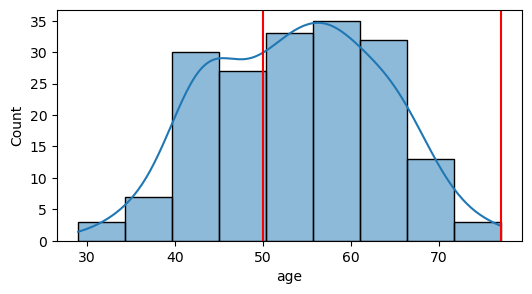

In [131]:
get_pdf_probability(df["age"],50,77)

### Observation:
##### Around 66% of patients are aged between 50 and 77 years,indicating the dataset has more elderly patients.

#### 9) What is the probability of patients whose maximum heart rate acheived(thalach) is below 120 bpm? 

In [135]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(df['thalach'])
ecdf(120)

0.09836065573770493

### Observation:
##### Around 9% of patients have maximum heart rate(thalach) below 120 bpm,indicating higher risk.

In [138]:
def stdNBgraph(df):
        # Converted to standard Normal Distribution
    import seaborn as sns
    mean=df.mean()
    std=df.std()
    values=[i for i in df]
    z_score=[((j-mean)/std) for j in values]
    sns.histplot(z_score,kde=True)
    z_score_mean=sum(z_score)/len(z_score)
    z_score_std=np.std(z_score)
    print("Mean of Z-scores:", z_score_mean)
    print("Standard Deviation of Z-scores:",z_score_std)


Mean of Z-scores: -4.1496860592546836e-16
Standard Deviation of Z-scores: 0.9972640167606986


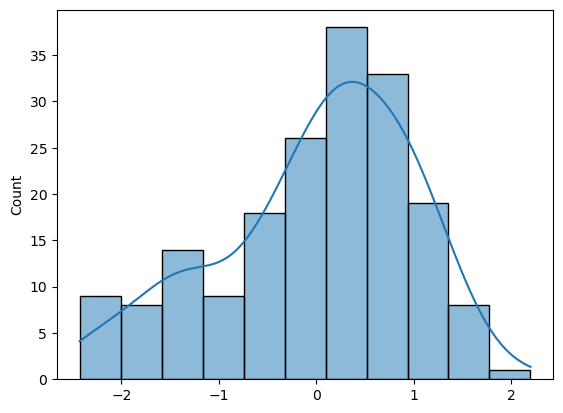

In [140]:
stdNBgraph(df["thalach"]) 

In [142]:
# Save the cleaned DataFrame
df.to_csv("heart_clean_out.csv", index=False)

# Bivariate Analysis

#### 10) What is the distribution of numerical features with respect to heart disease and sex?

#### a) What is the distribution and spread of age with respect to target?

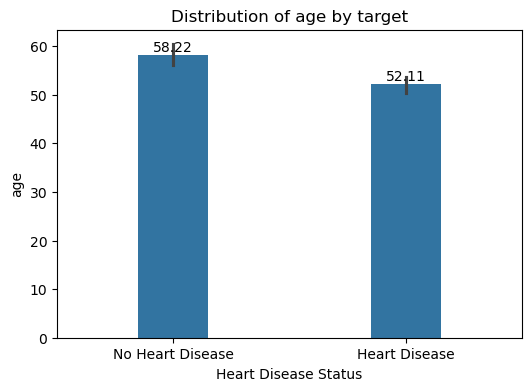

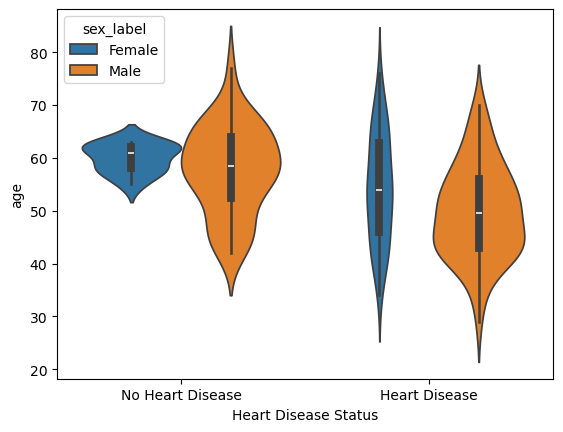

In [147]:
#barplot
plt.figure(figsize=(6,4))
ax=sns.barplot(x="target_label",y="age",data=df,width=0.3)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2,p.get_height()+0.13),ha='center',va='bottom')
plt.title(f"Distribution of age by target") 
plt.xlabel("Heart Disease Status")
plt.show()
#violin plot
sns.violinplot(x='target_label', y="age",hue='sex_label',data=df)
plt.xlabel("Heart Disease Status")
plt.show()

### Observation:
##### The barplot shows patients without heart disease have a higher mean age (58.22) compared to those with heart disease (52.11).
##### The violin plot for no heart disease:
##### Females show a narrow variation from 50 to 78 years with median age 62 years and peaking around 62 years.
##### Males show a wider variation from 35 to 85 years with median age 59 years and peaking around 60 years.
##### Overall, females have higher median and are more clustered near median while, the males are more spread out.
##### The violin plot for heart disease:
##### Females show a wider variation from 25 to 82 years with median 55 years and doesn't have sharp peaks.
##### Males show a wider variation from 20 to 75 years with median 50 years and peaking around 45 years.
##### Overall,both groups show wider varaition, females median is higher than males and males are highly clustered.
##### Overall,there is high overlap and less difference in median,indicating age alone cannot be a strong predictor of heart disease.

#### b) What is the distribution and spread of trestbps with respect to target?

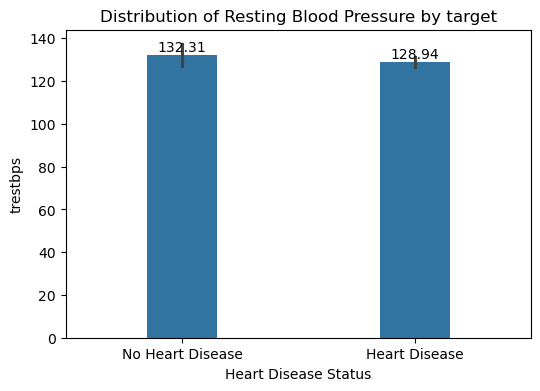

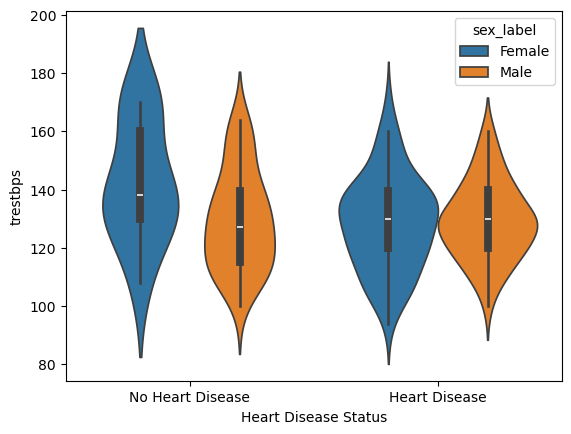

In [151]:
#barplot
plt.figure(figsize=(6,4))
ax=sns.barplot(x="target_label",y="trestbps",data=df,width=0.3)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2,p.get_height()+0.13),ha='center',va='bottom')
plt.title(f"Distribution of Resting Blood Pressure by target") 
plt.xlabel("Heart Disease Status")
plt.show()
#violin plot
sns.violinplot(x='target_label', y="trestbps",hue='sex_label',data=df)
plt.xlabel("Heart Disease Status")
plt.show()

### Observation:
##### The barplot shows patients without heart disease have a slightly higher mean resting blood pressure (132.31) compared to those with heart disease (128.94).
##### The violin plot for no heart disease:
##### Females show a wider variation from 80 to 190 mmHg, with median resting blood pressure 139 and peaking around 139.
##### Males show a wider variation from 80 to 180 mmHg, with median resting blood pressure 130 and peaking around 120.
##### Overall, both groups have wider variation, and femlaes have a slightly higher mean than males.
##### The violin plot for heart disease:
##### Females show a wider variation from 80 to 180 mmHg and are highly clustered, with a median resting blood pressure 135 and peaking around 139.
##### Males show a wider variation from 85 to 170 mmHg, with a median resting blood pressure 135 and peaking around 135.
##### Overall, both groups show similar median and are highly clustered.
##### Overall, there is high overlap and less difference in median, indicating trestbps alone is not a strong predictor in this dataset.

#### c) What is the distribution and spread of cholesterol with respect to target?

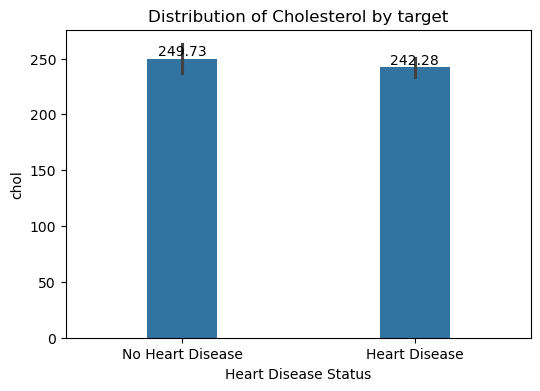

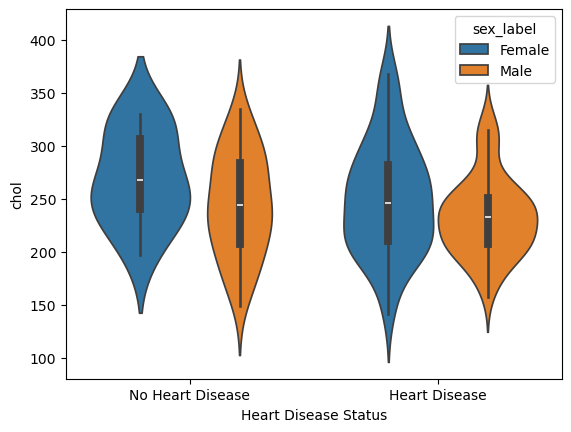

In [155]:
#barplot
plt.figure(figsize=(6,4))
ax=sns.barplot(x="target_label",y="chol",data=df,width=0.3)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2,p.get_height()+0.13),ha='center',va='bottom')
plt.title(f"Distribution of Cholesterol by target") 
plt.xlabel("Heart Disease Status")
plt.show()
#violin plot
sns.violinplot(x='target_label', y="chol",hue='sex_label',data=df)
plt.xlabel("Heart Disease Status")
plt.show()

### Observation:
##### The barplot shows patients without heart disease have slightly higher mean cholesterol(249.73 mg/dL) compared to those with heart disease(242.28 mg/dL).
##### The violin plot for no heart disease patients:
##### The female patients have a wider variation from 150 to 380 mg/dL with a median cholesterol 260 and peaking around 250.
##### The male patients have slightly wider variation from 110 to 370 mg/dL.
##### Overall, females have slightly higher median with more spread out than males.
##### The violin plot for heart disease patients:     
##### The females have wider variation from 100 to 400 mg/dL with median cholesterol 250 mg/dL and peaking around 250 mg/dL.
##### The males have narrower variation compared to the other groups ranges between 140 to 350 mg/dL with median cholesterol 240 mg/dL and peaking around 240 mg/dL.
##### Overall, males are more clustered and have lower median,while females have widest range, slightly highest median and are less clustered.
##### Overall,there is overlapping across the groups and there is slight difference in the median,indicating cholesterol alone cannot be a strong predictor of heart disease in this dataset.

#### d) What is the distribution and spread of thalach with respect to target?

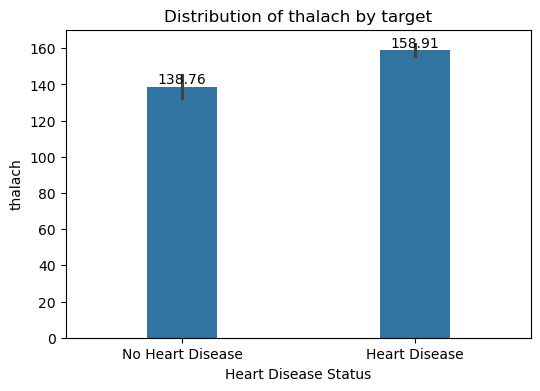

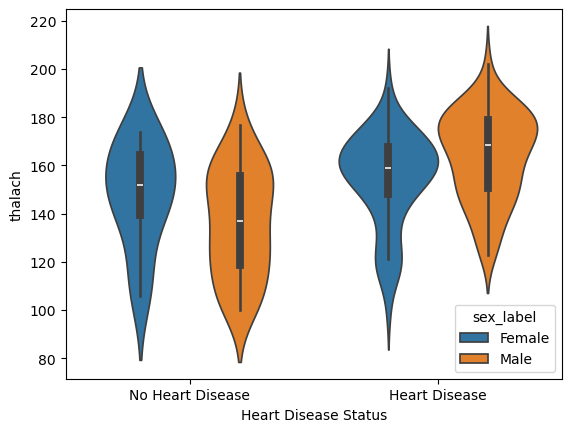

In [159]:
#barplot
plt.figure(figsize=(6,4))
ax=sns.barplot(x="target_label",y="thalach",data=df,width=0.3)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2,p.get_height()+0.13),ha='center',va='bottom')
plt.title(f"Distribution of thalach by target") 
plt.xlabel("Heart Disease Status")
plt.show()
#violin plot
sns.violinplot(x='target_label', y="thalach",hue='sex_label',data=df)
plt.xlabel("Heart Disease Status")
plt.show()

### Observation:
##### The barplot shows patients without heart disease have lower mean thalach(138.76) compared to those with heart disease(158.91).
##### The violin plot for no heart disease:
##### The females have wider variation from 80 to 200 with median 155 and peaking around 158.
##### The males have wider variation from 78 to 190 with median 138 and it is more spread out.
##### Overall, females have higher median and clustered, while males have lower median and less clustered.
##### The violin plot for heart disease:
##### The females have wider variation from 82 to 202 with median 160 and peaking around 160
##### The males have wider variation from 101 to 218 with median 170 and peaking around 180.
##### Overall, females have lower median and more spread out, while males have higher median and clustered around the center.
##### Overall, the median across groups have high difference and less overlap, thalach can be strong predictor in this dataset.

#### e) What is the distribution and spread of oldpeak with respect to target?

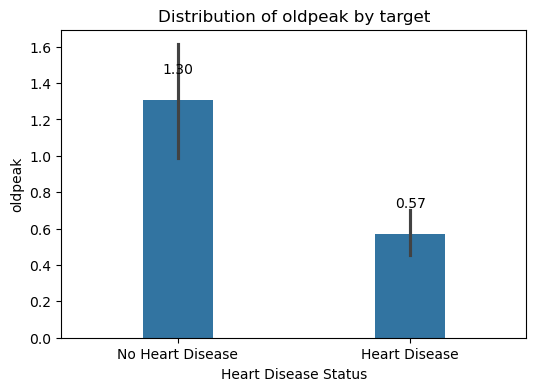

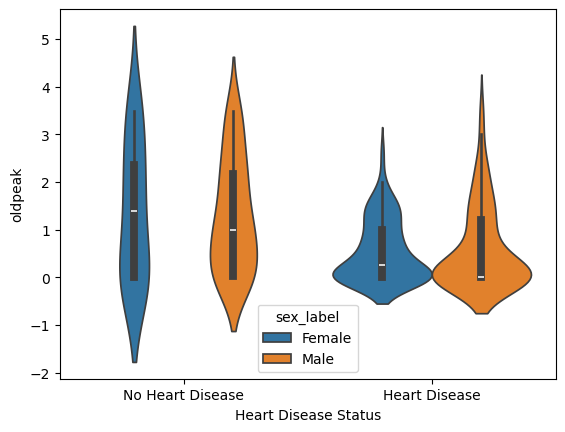

In [163]:
#barplot
plt.figure(figsize=(6,4))
ax=sns.barplot(x="target_label",y="oldpeak",data=df,width=0.3)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2,p.get_height()+0.13),ha='center',va='bottom')
plt.title(f"Distribution of oldpeak by target") 
plt.xlabel("Heart Disease Status")
plt.show()
#violin plot
sns.violinplot(x='target_label', y="oldpeak",hue='sex_label',data=df)
plt.xlabel("Heart Disease Status")
plt.show()

### Observation:
##### The barplot shows patients without heart disease have higher mean oldpeak(1.30) compared to those with heart disease(0.57).
##### The violin plot for no heart disease:
##### The females show wider variation from -2 to 5 with median oldpeak 1.5 and slightly peaking at 0
##### The males show wider variation from -1 to 4.5 with median oldpeak 1.0 and peaking around 0.5
##### Overall,both groups show a wider variation but males patients are more clustered at the center while median oldpeak is higher in females than males.
##### The violin plot for heart disease:
##### The females have a narrow variation from -0.8 to 3.2 with median oldpeak 0.3 and peaking around 0.2.
##### The males have a narrow variation from -0.6 to 4.3 with median oldpeak 0 and peaking around 0.
##### Overall, both groups have narrow variation and are highly clustered near 0.
##### Overall, there is less overlap and high difference in median and spread, indicating that oldpeak can be strong predictor in this dataset.

#### 11) What is the distribution of categorical features with respect to target?

#### a) What is the distribution of sex with respect to target?

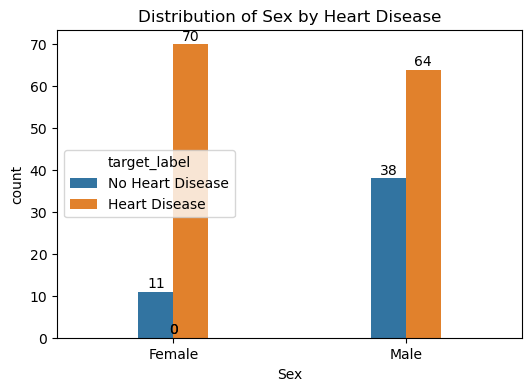

In [168]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="sex_label",data=df,hue="target_label",width=0.3)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of Sex by Heart Disease")
plt.xlabel("Sex")
plt.show()

### Observation:
##### Out of 81 females, 70 have heart disease and 11 without heart disease.
##### Out of 102 males, 64 have heart disease and 38 without heart disease.
##### In this dataset, the majority of female patients have heart disease.

#### b) What is the distribution of chest pain with respect to target?

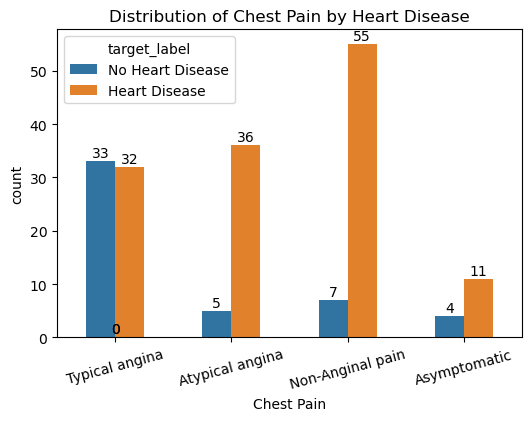

In [172]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="cp_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of Chest Pain by Heart Disease")
plt.xlabel("Chest Pain")
plt.xticks(rotation=15)
plt.show()

### Observation:
##### In typical angina, 33 patients do not have heart disease, and 32 patients have heart disease.
##### In atypical angina, 5 patients do not have heart disease, and 36 patients have heart disease.
##### In non-anginal, 7 patients do not have heart disease, and 55 patients have heart disease.
##### In asymptomatic patients, 4 do not have heart disease, and 11 have heart disease.
##### Overall, most patients with heart disease in the dataset experience non-anginal pain.

#### c) What is the distribution of fbs with respect to target?

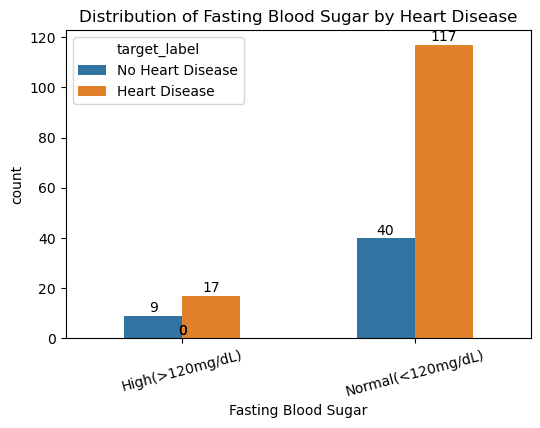

In [176]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="fbs_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of Fasting Blood Sugar by Heart Disease")
plt.xlabel("Fasting Blood Sugar")
plt.xticks(rotation=15)
plt.show()

### Observation:
##### 40 patients without heart disease and 117 patients with heart disease have normal fasting blood sugar.
##### 9 patients without heart disease and 17 patients with heart disease have high fasting blood sugar.
##### Overall, most patients have normal fasting blood sugar,indicating that fbs alone is not a strong predictor of heart disease in this dataset.

#### d) What is the distribution of restecg with respect to target?

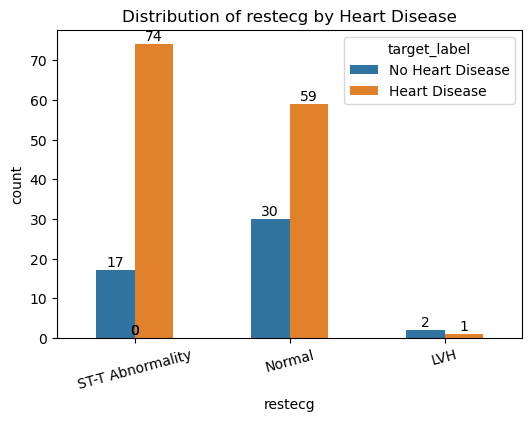

In [180]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="restecg_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of restecg by Heart Disease")
plt.xlabel("restecg")
plt.xticks(rotation=15)
plt.show()

### Observation:
##### 17 patients without heart disease and 74 patients with heart disease have ST-T Abnormality.
##### 30 patients without heart disease and 59 patients with heart disease have normal restecg.
##### 2 patients without heart disease and 1 patient with heart disease have LVH.
##### Overall, ST-T abnormality is more common in heart disease patients, indicating that restecg is a strong predictor in the dataset.

#### e) What is the distribution of exang with respect to target?

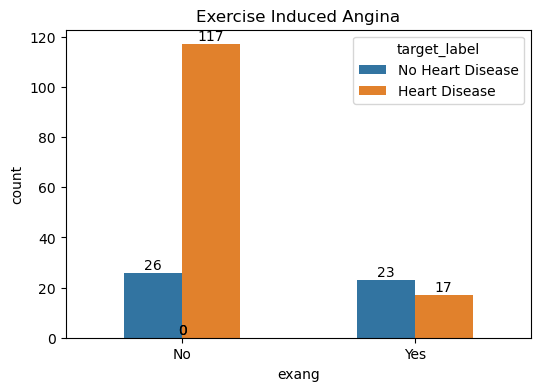

In [184]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="exang_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Exercise Induced Angina")
plt.xlabel("exang")
plt.show()

### Observation:
##### 26 patients without heart disease and 117 with heart disease do not experience chest pain during exercise.
##### 23 patients without heart disease and 17 patients with heart disease experience chest pain during exercise.
##### Overall, most patients with heart disease do not experience exercise induced angina(exang),indicating absence of exang is a strong predictor of heart disease in this dataset.

#### f) What is the distribution of slope with respect to target?

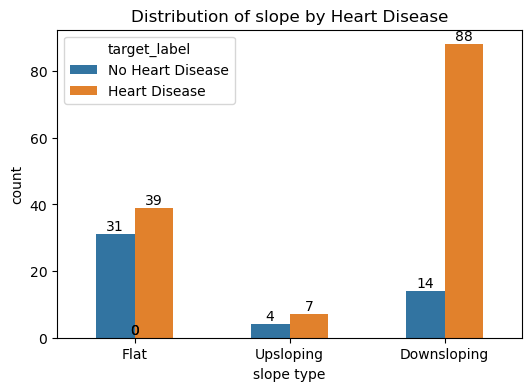

In [188]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="slope_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of slope by Heart Disease")
plt.xlabel("slope type")
plt.show()

### Observation:
##### 31 patients without heart disease and 39 with heart disease have flat slope.
##### 4 patients without heart disease and 7 with heart disease have upsloping.
##### 14 patients without heart disease and 88 patients with heart disease have downsloping.
##### Overall, most patients have downsloping, indicating that slope is a strong predictor in this dataset. 

#### g) What is the distribution of ca with respect to target?

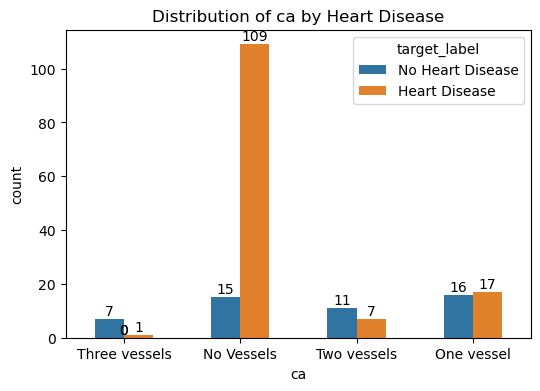

In [192]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="ca_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of ca by Heart Disease")
plt.xlabel("ca")
plt.show()

### Observation:
##### 7 patients without heart disease and 1 patient with heart disease have three vessels colored.
##### 15 patients without heart disease and 109 patient with heart disease have no vessels colored.
##### 11 patients without heart disease and 7 patients with heart disease have two vessels colored.
##### 16 patients without heart disease and 17 patients with heart disease have one vessel colored.
##### Overall, most patients with heart disease have no colored vessels, indicating absence of colored vessels is a strong predictor of heart disease in this dataset.

#### h) What is the distribution of thal with respect to target?

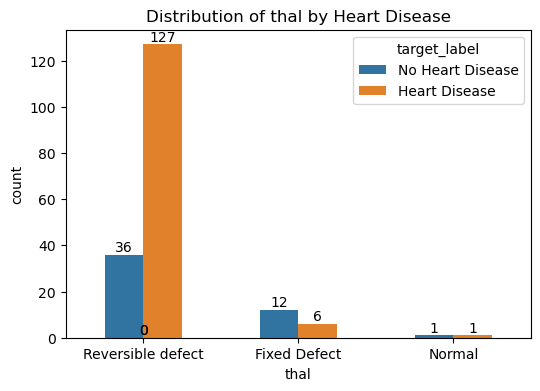

In [196]:
plt.figure(figsize=(6,4))
ax=sns.countplot(x="thal_label",data=df,hue="target_label",width=0.5)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height() + 0.2),ha='center', va='bottom')
plt.title("Distribution of thal by Heart Disease")
plt.xlabel("thal")
plt.show()

### Observation:
##### 36 patients without heart disease and 127 with heart disease have reversible defect.
##### 12 patients without heart disease and 6 patients with heart disease have fixed defect.
##### 1 patient without heart disease and 1 patient with heart disease have normal blood flow.
##### Overall, most patients with heart disease have reversible blood flow defect, indicating that thal is a strong predictor of heart disease in this dataset.

#### 12) What is the direction of the relationship between numerical variables in the dataset?

In [200]:
covariance=df[quan].cov()
print("Covariance_matrix:\n",covariance)

Covariance_matrix:
                  age    trestbps         chol     thalach   oldpeak
age        91.903501   44.361046   104.491450 -100.914130  1.623170
trestbps   44.361046  253.716508   116.027488  -25.511559  2.322335
chol      104.491450  116.027488  2209.858182   23.390440 -0.297098
thalach  -100.914130  -25.511559    23.390440  485.503933 -7.033348
oldpeak     1.623170    2.322335    -0.297098   -7.033348  0.911537


### Observation:
##### age,trestbps, and oldpeak increase together, showing positive covariance.
##### thalach decreases as age, trestbps, and oldpeak increase, indicating negative covariance.
##### cholesterol increases with age, trestbps and thalach but decreases slightly with oldpeak.

#### 11) What is the strength and direction of linear relationships among the numerical variables in the dataset?

In [204]:
#correlation matrixc
correlation_matrix=df[quan].corr()
print("Correlation_matrix:\n",correlation_matrix)

Correlation_matrix:
                age  trestbps      chol   thalach   oldpeak
age       1.000000  0.290510  0.231864 -0.477738  0.177342
trestbps  0.290510  1.000000  0.154955 -0.072689  0.152709
chol      0.231864  0.154955  1.000000  0.022582 -0.006620
thalach  -0.477738 -0.072689  0.022582  1.000000 -0.334332
oldpeak   0.177342  0.152709 -0.006620 -0.334332  1.000000


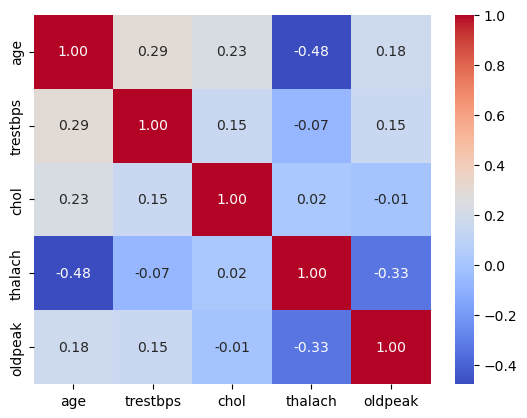

In [206]:
#heatmap
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f")
plt.show()

### Observation:
##### Most variables show weak positive correlations with each other.
##### thalach shows a moderate negative correlation with age(-0.48) and oldpeak(-0.33).
##### This indicates that thalach tends to decreases as age and oldpeak increases.

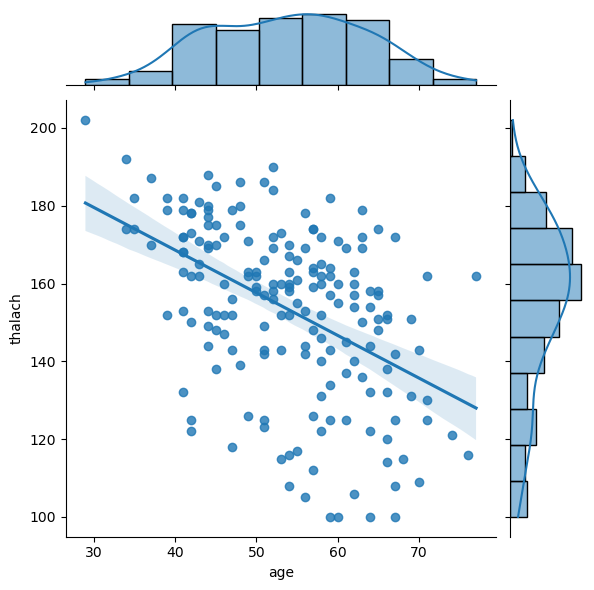

In [209]:
#joint plot
sns.jointplot(df,x="age",y="thalach",kind="reg")
plt.show()

### Observation:
##### The joint plot shows a negative trend between age and thalach.
##### As age increases, thalach tends to decrease, confirming the moderate negative correlation observed in the correlation matrix.

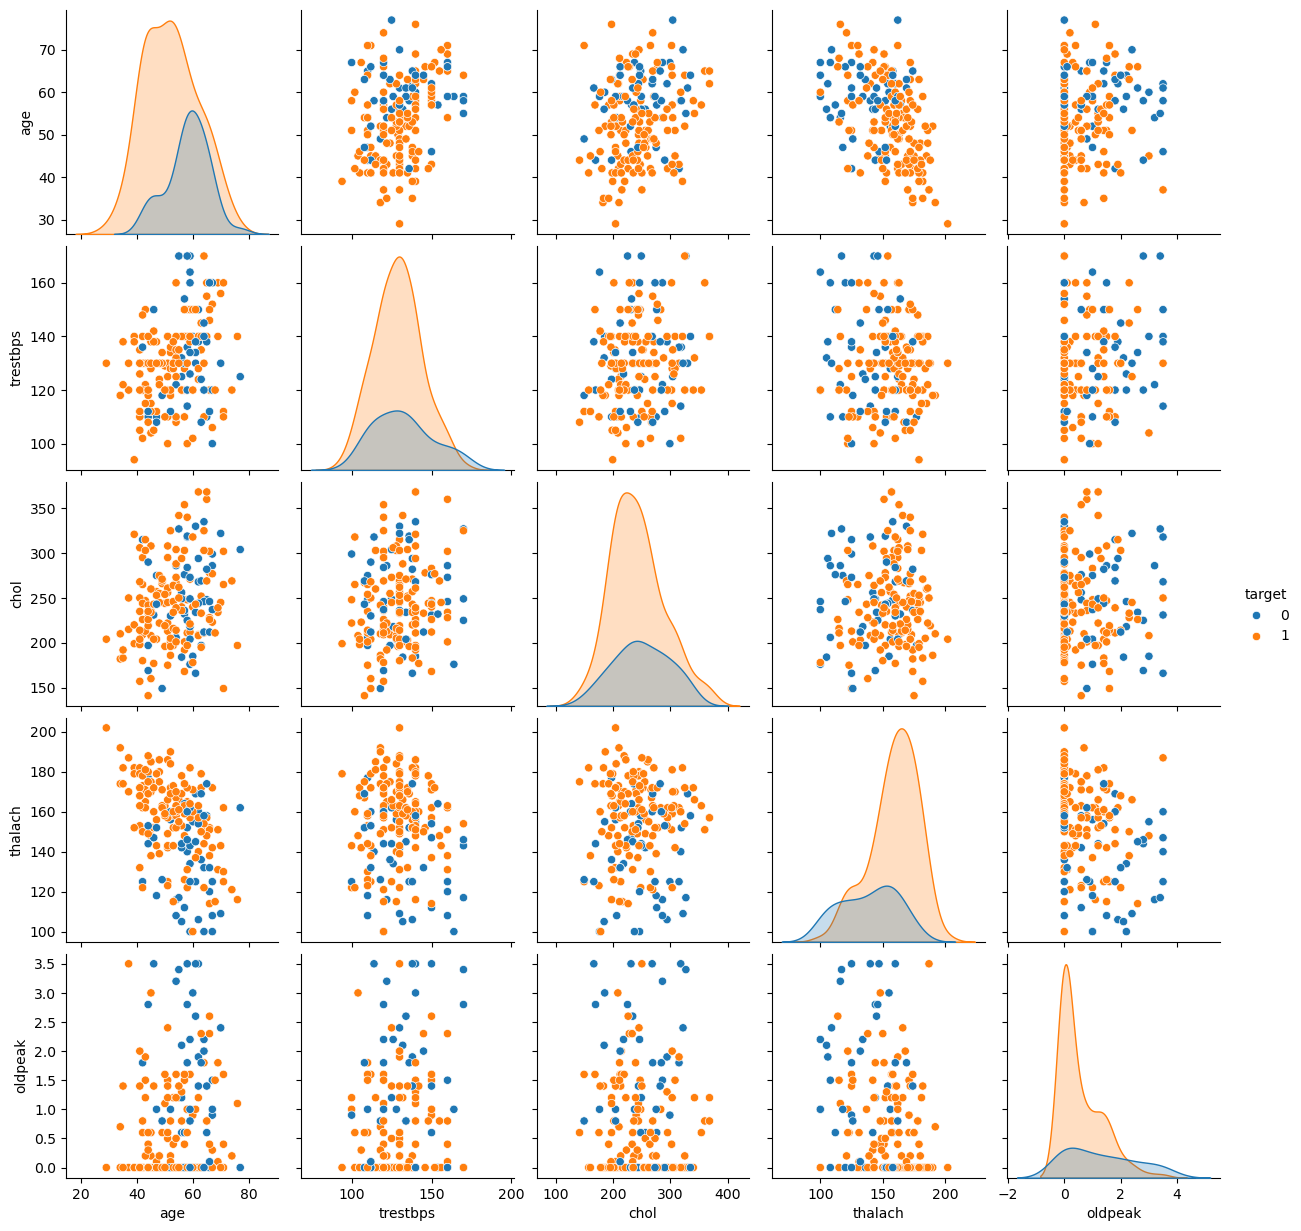

In [212]:
x=df[quan+['target']]
sns.pairplot(x, hue='target')
plt.show()

### Observation:
##### The pairplot shows that age ,trestbps and cholesterol have high overlap between the two target groups, indicating these features are weak predictors
##### thalach and oldpeak shows clear separation between the target groups, indiacting these are strong predictors.
##### Patients with heart disease tend to have higher thalach values and lower oldpeak values.

#### 14) Does the dataset exhibit multicollinearity among numerical variables?

In [215]:
#calculating vif
def calc_vif(df,quan):
    vif=pd.DataFrame()
    vif["Variables"]=df[quan].columns
    vif["VIF"]=[variance_inflation_factor(df[quan].values,i)for i in range(df[quan].shape[1])]
    return vif

In [218]:
vif=calc_vif(df,quan)
vif

Variables        VIF
0       age  35.753875
1  trestbps  65.098939
2      chol  30.169437
3   thalach  33.458008
4   oldpeak   1.841626

### Observation:
##### age, trestbps, cholesterol, thalach have high VIF values, indicating multicollinearity.
##### oldpeak has low VIF(1.84), indicating it is not correlated with the other variables.

#### 15) Is there a significant difference in the mean of the numerical variables between patients with and without heart disease?

In [222]:
#Independent t-test
results=[]
for column in quan:
    group0=df[df["target"]==0][column]
    group1=df[df["target"]==1][column]
    t_stat,p_val=ttest_ind(group0,group1)
    results.append([column,t_stat,p_val])
ttest_df=pd.DataFrame(results,columns=["Variables","T-statistic","P-value"])
ttest_df["Significant"]=ttest_df["P-value"].apply(lambda x:"Yes" if x<0.05 else "No")
ttest_df["T-statistic"] = ttest_df["T-statistic"].round(3)
ttest_df["P-value"] = ttest_df["P-value"].round(4)
print(ttest_df)

  Variables  T-statistic  P-value Significant
0       age        3.971   0.0001         Yes
1  trestbps        1.268   0.2065          No
2      chol        0.950   0.3436          No
3   thalach       -5.980   0.0000         Yes
4   oldpeak        4.874   0.0000         Yes


### Observation:
##### Among the numerical variables, age, thalach, oldpeak show statistically significant differences between patients with and without heart disease.
##### trestbps and cholesterol do not show significant differences, indicating their mean values are similar across two groups.

#### 16) Is there a significant difference in the mean of the cholesterol(chol) between different groups of chest pain(cp)?

In [226]:
# One-way ANOVA test
from scipy.stats import f_oneway
group0=df[df["cp"]==0]["chol"]
group1=df[df["cp"]==1]["chol"]
group2=df[df["cp"]==2]["chol"]
group3=df[df["cp"]==3]["chol"]
f_stat,p_val=f_oneway(group0,group1,group2,group3)
print(f"F-statistic:{round(f_stat,3)}")
print(f"P-value:{round(p_val,4)}")

F-statistic:0.846
P-value:0.4703


### Observation:
##### It fails to reject null hypothesis.
##### There is no significant difference in the mean of cholesterol between different groups of chest pain.

#### 17) Is there a significant difference in the mean of the cholesterol between different groups of major vessels colored(ca)?

In [230]:
# One-way Anova test
group0=df[df["ca"]==0]["chol"]
group1=df[df["ca"]==1]["chol"]
group2=df[df["ca"]==2]["chol"]
group3=df[df["ca"]==3]["chol"]
f_stat,p_val=f_oneway(group0,group1,group2,group3)
print(f"F-statistic:{round(f_stat,3)}")
print(f"P-value:{round(p_val,4)}")

F-statistic:1.6
P-value:0.191


### Observation:
##### It fails to reject null hypothesis.
##### There is no significant difference in the mean of cholesterol between different groups of ca.

#### 18) Is there a significant difference in the mean of the thalach between slope and thal?

In [234]:
# Two-way Anova test
import statsmodels.api as sm
from statsmodels.formula.api import ols
model=ols('thalach ~C(slope)+C(thal)+C(slope):C(thal)',data=df).fit()

In [236]:
anova_result=sm.stats.anova_lm(model,type=2)
anova_result

df        sum_sq      mean_sq          F        PR(>F)
C(slope)            2.0  16697.768788  8348.884394  21.772722  3.596875e-09
C(thal)             2.0   2673.488498  1336.744249   3.486042  3.276514e-02
C(slope):C(thal)    4.0   1906.598462   476.649616   1.243036  2.944835e-01
Residual          175.0  67104.827131   383.456155        NaN           NaN

### Observation:
##### There is a significant difference in thalach across different slope categories. 
##### There is a significant difference in thalach across different thal categories.
##### The interaction effect of slope and thal on thalach is not statistically significant.

#### 19) Which numerical and categorical features are strong predictors of heart disease?

### Strong Numerical Predictors:
##### thalach-higher in heart disease patients.
##### oldpeak-lower in heart disease patients.
### Strong Categorical Predictors:
##### slope-downsloping is more common in heart disease patients.
##### ca-absence of colored vessels is more common in heart disease patients.
##### thal-most heart disease patients have reversible blood flow defect.

In [241]:
df.drop(["target_label","sex_label","cp_label","fbs_label","restecg_label","exang_label","slope_label","ca_label","thal_label"],axis=1,inplace=True)

In [243]:
# Save the cleaned DataFrame
df.to_csv("heart_clean_final.csv", index=False)

In [245]:
df

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     62    0   0       138  294.0    1        1      106      0      1.9   
1     58    0   0       100  248.0    0        0      122      0      1.0   
2     58    1   0       114  318.0    0        2      140      0      3.5   
3     54    1   0       122  286.0    0        0      116      1      3.2   
4     71    0   0       112  149.0    0        1      125      0      1.6   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
178   60    0   2       120  178.0    1        1      100      0      0.0   
179   64    1   2       140  335.0    0        1      158      0      0.0   
180   68    0   2       120  211.0    0        0      115      0      1.5   
181   44    0   2       108  141.0    0        1      175      0      0.6   
182   59    1   3       160  273.0    0        0      125      0      0.0   

     slope  ca  thal  target  
0        1   3     2       0  
1        1   0     2       1  
2        0   3     1       0  
3        1   2     2       0  
4        1   0     2       1  
..     ...  ..   ...     ...  
178      2   0     2       1  
179      2   0     2       0  
180      1   0     2       1  
181      1   0     2       1  
182      2   0     2       0  

[183 rows x 14 columns]